# Arbol de decisión

Se crea un arbol de decisón basandonos en las caracteristicas de la red neuronal

In [959]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn.preprocessing import StandardScaler
import random
import ast

In [960]:
# Semilla
seed = random.randint(0, 1000)
print(f"Semilla: {seed}")

Semilla: 819


In [961]:
def paint_results(y_test, y_pred, order = True):
  # Grafica de la predicción y la realidad
  linespace = np.linspace(0, 1, y_pred.size)
  if order:
    # Ordena los pares test pred para que se vean mejor
    y_test, y_pred = zip(*sorted(zip(y_test, y_pred)))

  plt.plot(linespace, y_test, label="Real", marker="o")
  plt.plot(linespace, y_pred, label="Predicción", marker="x")
  plt.legend()
  plt.title("Real vs Predicción")
  plt.show()
  
def paint_real_vs_pred(y_test, y_pred):
  # Grafica de la predicción y la realidad
  plt.scatter(y_test, y_pred, marker="o")
  plt.xlabel("Real")
  plt.ylabel("Predicción")
  plt.title("Real vs Predicción")
  plt.show()
  # linealidad
  pearson = pearsonr(y_test, y_pred)[0]
  spearman = spearmanr(y_test, y_pred)[0]
  print(f"Pearson: {pearson:.4f}, Spearman: {spearman:.4f}")

Mean Absolute Error:  0.10941221606844367
R2:  0.12891290780886488


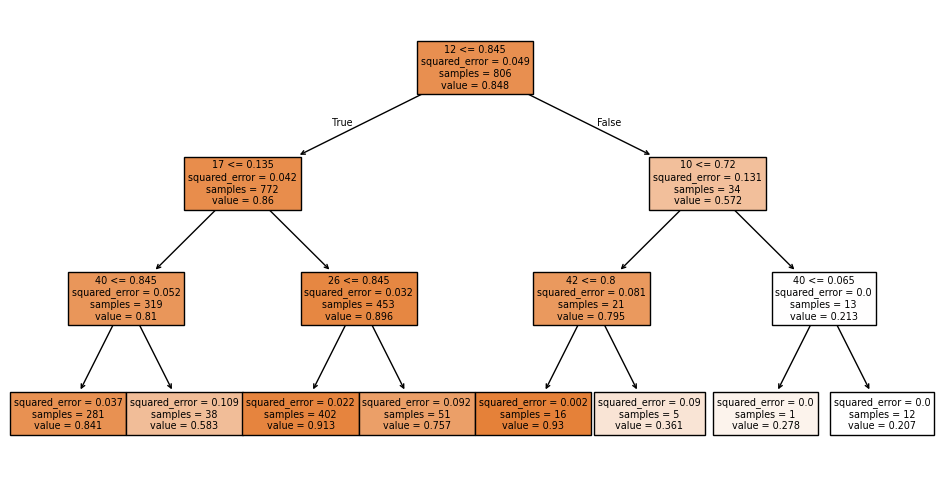

In [962]:
# lee el df
df = pd.read_csv("./results_transformed_1000.csv")

# Definir variables
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Crear y entrenar arbol
model = DecisionTreeRegressor(random_state=seed, max_depth=3)
regressor = model.fit(X_train, y_train)

# Predecir
y_pred = regressor.predict(X_test)

# Calcular error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

# Visualizar el árbol de decisión
plt.figure(figsize=(12, 6))
plot_tree(regressor, feature_names=X.columns, filled=True)
plt.show()

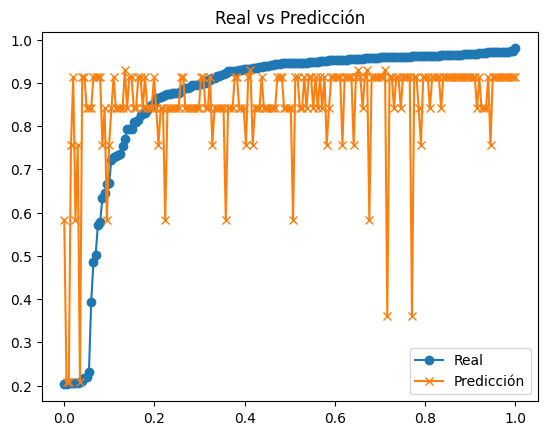

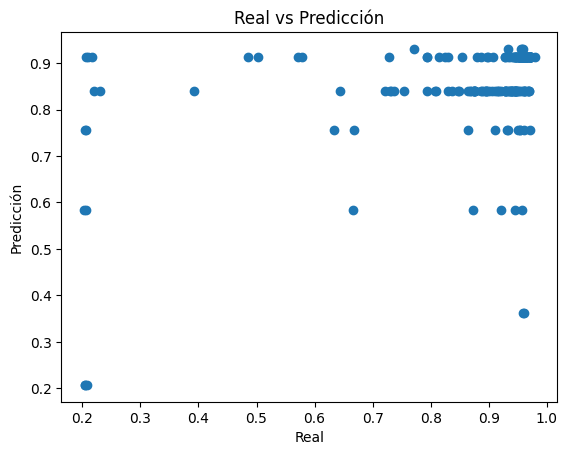

Pearson: 0.4204, Spearman: 0.4119


In [963]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

# Bosques aleatorios

In [964]:
from sklearn.ensemble import RandomForestRegressor

In [965]:
# lee el df
df = pd.read_csv("./results_transformed_1000.csv")

# Definir variables
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Crear y entrenar modelo
model = RandomForestRegressor(random_state=seed, n_estimators=500, max_depth=6)

model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)

# Calcular error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

Mean Absolute Error:  0.1030529714987619
R2:  0.32356395842811203


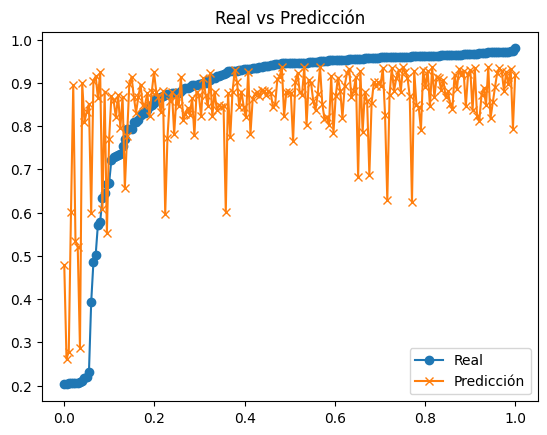

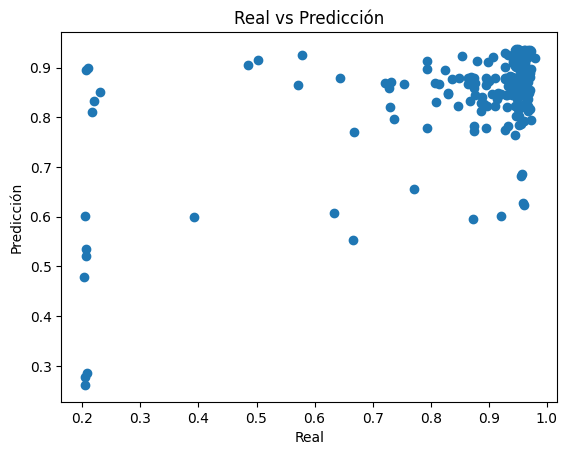

Pearson: 0.5814, Spearman: 0.3849


In [966]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

# XGBRegressor

In [967]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
# Leer el DataFrame
df = pd.read_csv("./results_transformed_1000.csv")

# Definir variables (expandir listas en columnas)
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Escalar características (opcional, XGBoost maneja datos sin escalar, pero ayuda en algunos casos)
scaler_X = MinMaxScaler()
X_train_scaled = X_train
X_test_scaled = X_test

# Crear y entrenar el modelo XGBoost
model = XGBRegressor(
    n_estimators=500,      # Número de árboles (boosting rounds)
    learning_rate=0.005,     # Tasa de aprendizaje
    max_depth=4,           # Profundidad máxima de los árboles
    random_state=seed, 
    objective='reg:pseudohubererror',  # Objetivo de regresión
)
model.fit(X_train_scaled, y_train)

# Predecir
y_pred = model.predict(X_test_scaled)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Absolute Error: 0.08508484664972465
R² Score: 0.26358135910598024


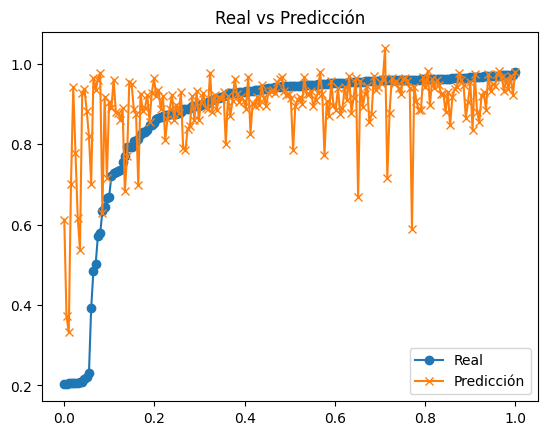

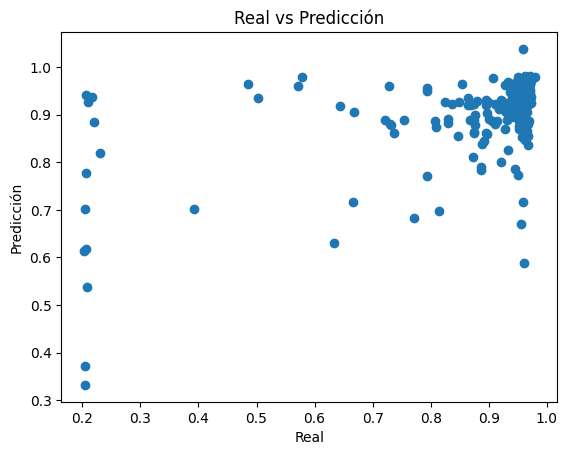

Pearson: 0.5347, Spearman: 0.4048


In [968]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

## OPtuna con XGBRegressor

In [969]:
import ast
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr, spearmanr

# 1. Lee tus datos
df = pd.read_csv("./results_transformed_1000.csv")

X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# 2. Split train/valid fijo para evaluación en cada trial
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# 3. Función objetivo multi-objetivo
def objective(trial):
    # Espacio de búsqueda
    params = {
        "n_estimators":      trial.suggest_int("n_estimators",      50, 1000),
        "learning_rate":     trial.suggest_float("learning_rate",   0.001, 0.1, log=True),
        "max_depth":         trial.suggest_int("max_depth",           3,    30),
        "subsample":         trial.suggest_float("subsample",         0.5,   1.0),
        "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.5,   1.0),
        "gamma":             trial.suggest_float("gamma",              0.0,   5.0),
        "reg_alpha":         trial.suggest_float("reg_alpha",          0.0,   5.0),
        "reg_lambda":        trial.suggest_float("reg_lambda",         0.0,   5.0),
        "random_state":      seed,
        "objective":         "reg:squarederror",
        "verbosity":         0,
        "n_jobs":           -1
    }

    # Entrena en train, evalúa en validación
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Predice en validación
    preds = model.predict(X_valid)

    # 1) error
    mae = mean_absolute_error(y_valid, preds)

    # 2) Pearson (optuna maximizará)
    # scipy.stats.pearsonr devuelve (corr, p-value)
    corr, _ = spearmanr(y_valid, preds)
    corr = corr if np.isnan(corr) else corr

    # Retornamos (pearson, rmse)
    return corr, mae

# 4. Crea estudio multi-objetivo
study = optuna.create_study(
    directions=["maximize", "minimize"],
    study_name="xgb_reg_pearson_rmse"
)

# 5. Corre la optimización
study.optimize(objective, n_trials=1500, n_jobs=-1)

# 6. Imprime el frente de Pareto
print("▶ Número de trials:", len(study.trials))
print("▶ Frente de Pareto (Spearman ↑, MAE ↓):")
for t in study.best_trials:
    corr, rmse = t.values
    print(f"  Trial #{t.number:02d}: Spearman={corr:.4f}, MAE={rmse:.4f}")
    for k, v in t.params.items():
        print(f"     • {k}: {v}")


[I 2025-05-11 23:34:26,427] A new study created in memory with name: xgb_reg_pearson_rmse
C:\Users\Jafet\AppData\Local\Temp\ipykernel_24904\719344028.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(y_valid, preds)
[W 2025-05-11 23:34:27,002] Trial 18 failed with parameters: {'n_estimators': 69, 'learning_rate': 0.01393793779359242, 'max_depth': 10, 'subsample': 0.5130263747074819, 'colsample_bytree': 0.8272117905854606, 'gamma': 2.5771589237988013, 'reg_alpha': 3.965827680983728, 'reg_lambda': 2.687716341667975} because of the following error: The value nan is not acceptable.
[W 2025-05-11 23:34:27,006] Trial 18 failed with value (nan, 0.1306770812270075).
C:\Users\Jafet\AppData\Local\Temp\ipykernel_24904\719344028.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(y_valid, preds)
[W 2025-05-11 23:34:27,126] Trial 0 failed with parameters: {

▶ Número de trials: 1500
▶ Frente de Pareto (Spearman ↑, MAE ↓):
  Trial #1045: Spearman=0.5142, MAE=0.1146
     • n_estimators: 198
     • learning_rate: 0.02738629509900002
     • max_depth: 23
     • subsample: 0.6076376830334624
     • colsample_bytree: 0.8568734773407267
     • gamma: 0.061371221454309954
     • reg_alpha: 2.0556323513397645
     • reg_lambda: 4.385482031927584
  Trial #1073: Spearman=0.4139, MAE=0.0961
     • n_estimators: 168
     • learning_rate: 0.09342155862608265
     • max_depth: 26
     • subsample: 0.9959906436097347
     • colsample_bytree: 0.9591464112768868
     • gamma: 0.061371221454309954
     • reg_alpha: 0.19177563302300749
     • reg_lambda: 0.2194109294479374
  Trial #1092: Spearman=0.5113, MAE=0.1109
     • n_estimators: 168
     • learning_rate: 0.04757034148113911
     • max_depth: 23
     • subsample: 0.6076376830334624
     • colsample_bytree: 0.8568734773407267
     • gamma: 0.061371221454309954
     • reg_alpha: 1.4362955505380692
     • 

Replicación

In [970]:
# 1. Lee tus datos
df = pd.read_csv("./results_transformed_1000.csv")
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# 2. Split train/valid (fijo)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# 3. Recorre el frente de Pareto
print("Evaluando el frente de Pareto:")
for trial in study.best_trials:
    print(f"\n▶ Trial #{trial.number}:")
    # 4. Extrae los parámetros de este trial
    params = trial.params.copy()
    print("  Parámetros:")
    for k, v in params.items():
        print(f"     • {k}: {v}")
    #   (si quieres, puedes fijar aquí objective / verbosity / n_jobs)
    params.update({
        "objective": "reg:squarederror",
        "verbosity": 0,
        "n_jobs": -1
    })

    # 5. Crea y entrena el modelo
    model = XGBRegressor(**params, random_state=seed)
    model.fit(X_train, y_train)

    # 6. Predice y calcula métricas
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    r2  = r2_score(y_valid, y_pred)

    # 7. Imprime resultados
    print(f"   MAE = {mae:.4f}")
    print(f"   R²  = {r2:.4f}")
    
    break

Evaluando el frente de Pareto:

▶ Trial #1045:
  Parámetros:
     • n_estimators: 198
     • learning_rate: 0.02738629509900002
     • max_depth: 23
     • subsample: 0.6076376830334624
     • colsample_bytree: 0.8568734773407267
     • gamma: 0.061371221454309954
     • reg_alpha: 2.0556323513397645
     • reg_lambda: 4.385482031927584
   MAE = 0.1146
   R²  = 0.1815


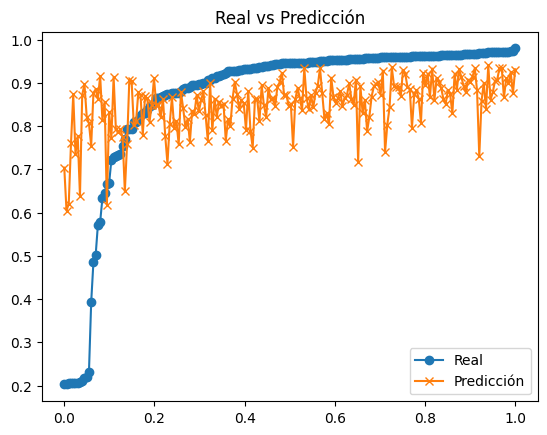

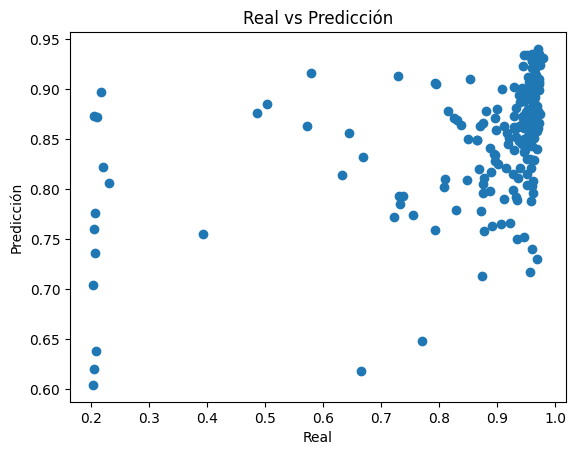

Pearson: 0.4551, Spearman: 0.5142


In [971]:
# Grafica de la predicción y la realidad
paint_results(y_valid, y_pred, order=True)
paint_real_vs_pred(y_valid, y_pred)

# Extra trees

In [972]:
from sklearn.ensemble import ExtraTreesRegressor

# Leer el DataFrame
df = pd.read_csv("./results_transformed_1000.csv")

# Definir variables (expandir listas en columnas)
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Modelo Extra Trees para regresión
model = ExtraTreesRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=seed,
    n_jobs=-1
)

# Entrenar
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test_scaled)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Absolute Error: 0.11789933128066596
R² Score: 0.2777312904401158


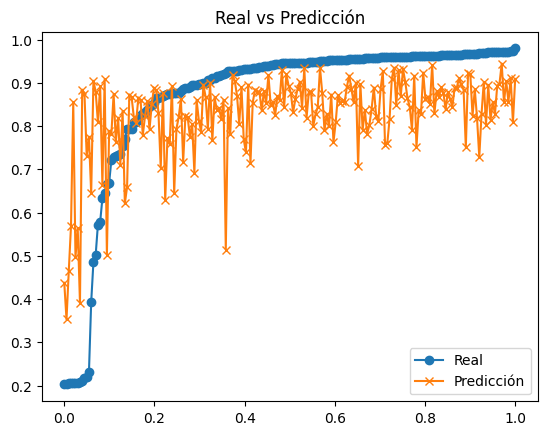

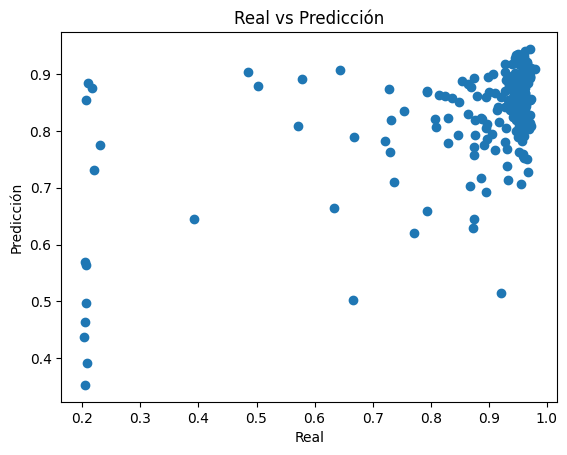

Pearson: 0.5748, Spearman: 0.3806


In [973]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

In [974]:
import ast
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
from sklearn.ensemble import ExtraTreesRegressor

# Semilla para reproducibilidad
seed = 42

# 1. Lee tus datos
df = pd.read_csv("./results_transformed_1000.csv")
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series)
y = df["val_iou"]

# 2. Split train/test fijo para evaluar cada trial
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# 3. Define la función objetivo multi-objetivo
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    params = {
        "n_estimators":       trial.suggest_int("n_estimators",       100, 1000),
        "max_depth":          trial.suggest_int("max_depth",          2,   20),
        "min_samples_split":  trial.suggest_int("min_samples_split",  2,   20),
        "min_samples_leaf":   trial.suggest_int("min_samples_leaf",   1,   20),
        "max_features":       trial.suggest_float("max_features",     0.1, 1.0),
        "bootstrap":          trial.suggest_categorical("bootstrap", [True, False]),
        "random_state":       seed,
        "n_jobs":            -1
    }

    # 3a. Entrena el modelo
    model = ExtraTreesRegressor(**params)
    model.fit(X_train, y_train)

    # 3b. Predice en test
    y_pred = model.predict(X_test)

    # 1) MAE (Optuna minimizará)
    mae = mean_absolute_error(y_test, y_pred)

    # 2) Spearman (Optuna maximizará)
    corr, _ = spearmanr(y_test, y_pred)
    # Evita nan si predicciones constantes
    if pd.isna(corr):
        corr = 0.0

    # Importante: el orden de retorno debe coincidir con 'directions'
    return mae, corr

# 4. Crea el estudio multi-objetivo
study = optuna.create_study(
    directions=["minimize", "maximize"],
    study_name="extra_trees_mae_spearman"
)

# 5. Lanza la optimización
study.optimize(objective, n_trials=2500, n_jobs=-1)

# 6. Muestra el frente de Pareto
print(f"▶ Num. trials: {len(study.trials)}")
print("▶ Frente de Pareto (MAE ↓, Spearman ↑):")
for t in study.best_trials:
    mae, corr = t.values
    print(f"  Trial #{t.number:02d}: MAE={mae:.4f}, Spearman={corr:.4f}")
    for k, v in t.params.items():
        print(f"    • {k}: {v}")


[I 2025-05-11 23:36:35,209] A new study created in memory with name: extra_trees_mae_spearman
[I 2025-05-11 23:36:45,113] Trial 2 finished with values: [0.1086286053138267, 0.4837056972368805] and parameters: {'n_estimators': 127, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 0.8261009630144122, 'bootstrap': False}.
[I 2025-05-11 23:36:45,432] Trial 7 finished with values: [0.1195321485612668, 0.5295060569949356] and parameters: {'n_estimators': 161, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.14770890179118853, 'bootstrap': False}.
[I 2025-05-11 23:36:45,478] Trial 4 finished with values: [0.12089488791828262, 0.4173491902531919] and parameters: {'n_estimators': 186, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 0.10154810881219081, 'bootstrap': False}.
[I 2025-05-11 23:36:45,516] Trial 15 finished with values: [0.11552777634635447, 0.5005215836634027] and parameters: {'n_estimato

▶ Num. trials: 2500
▶ Frente de Pareto (MAE ↓, Spearman ↑):
  Trial #546: MAE=0.1067, Spearman=0.4984
    • n_estimators: 270
    • max_depth: 13
    • min_samples_split: 20
    • min_samples_leaf: 7
    • max_features: 0.9683109343501146
    • bootstrap: False
  Trial #685: MAE=0.1101, Spearman=0.5094
    • n_estimators: 771
    • max_depth: 11
    • min_samples_split: 5
    • min_samples_leaf: 10
    • max_features: 0.7431506195001447
    • bootstrap: False
  Trial #741: MAE=0.1058, Spearman=0.4960
    • n_estimators: 270
    • max_depth: 12
    • min_samples_split: 18
    • min_samples_leaf: 7
    • max_features: 0.9392051786974434
    • bootstrap: False
  Trial #775: MAE=0.1056, Spearman=0.4875
    • n_estimators: 605
    • max_depth: 18
    • min_samples_split: 3
    • min_samples_leaf: 5
    • max_features: 0.9392051786974434
    • bootstrap: False
  Trial #859: MAE=0.1128, Spearman=0.5238
    • n_estimators: 313
    • max_depth: 12
    • min_samples_split: 10
    • min_samples_l

In [975]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Ya tienes X_train, X_valid, y_train, y_valid, y el 'study' construido

print("Evaluando el frente de Pareto con ExtraTreesRegressor:")
for trial in study.best_trials:
    print(f"\n▶ Trial #{trial.number}:")
    
    # 2. Extrae y muestra parámetros sugeridos por Optuna
    params = trial.params.copy()
    print("  Parámetros:")
    for k, v in params.items():
        print(f"     • {k}: {v}")
    
    # 3. Agrega los parámetros fijos necesarios
    params.update({
        "random_state": seed,
        "n_jobs": -1
    })
    
    # 4. Construye y entrena el modelo Extra Trees
    model = ExtraTreesRegressor(**params)
    model.fit(X_train, y_train)
    
    # 5. Predice en validación y calcula métricas
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    r2  = r2_score(y_valid, y_pred)
    
    # 6. Imprime resultados
    print(f"   MAE = {mae:.4f}")
    print(f"   R²  = {r2:.4f}")
    
    # Si solo quieres ver el primer punto del frente, descomenta la siguiente línea:
    break


Evaluando el frente de Pareto con ExtraTreesRegressor:

▶ Trial #546:
  Parámetros:
     • n_estimators: 270
     • max_depth: 13
     • min_samples_split: 20
     • min_samples_leaf: 7
     • max_features: 0.9683109343501146
     • bootstrap: False
   MAE = 0.0925
   R²  = 0.5054


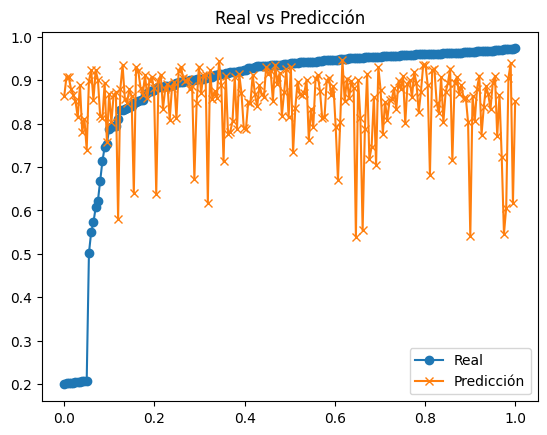

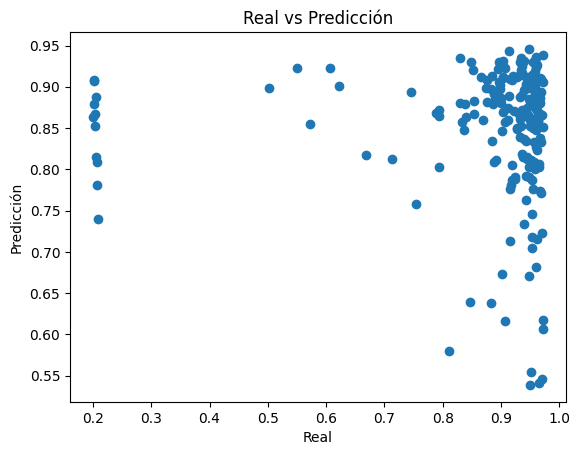

Pearson: -0.0336, Spearman: -0.0845


In [976]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)

# Perceptrón multicapa

In [977]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Definir la red neuronal corregida
class MLP(nn.Module):
  def __init__(self, input_dim):
    super(MLP, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.Dropout(0.4),
      
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Dropout(0.3),
      
      nn.Linear(64, 1)
    )
  
  def forward(self, x):
    return self.model(x)

# Leer y preparar los datos
df = pd.read_csv("./results_transformed_1000.csv")
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series).to_numpy()
X = np.nan_to_num(X, nan=-1)  # Reemplazar NaN por -1
y = df["val_iou"].to_numpy()

# Escalar características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Inicializar modelo, pérdida y optimizador
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reducir learning rate

# Entrenamiento
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:  # Mini-lotes
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {total_loss / len(train_loader)}")

# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}, R²: {r2:.4f}")

Epoch 0 - Loss: 0.5165066196053636
Epoch 10 - Loss: 0.07305694532160666
Epoch 20 - Loss: 0.06264413343559877
Epoch 30 - Loss: 0.0572081162210773
Epoch 40 - Loss: 0.04982972612567976
Epoch 50 - Loss: 0.0488469834238583
Epoch 60 - Loss: 0.04360216015986368
Epoch 70 - Loss: 0.043744215449573944
Epoch 80 - Loss: 0.03723462369731244
Epoch 90 - Loss: 0.035666213407382075
MAE: 0.1385, R²: -0.2252


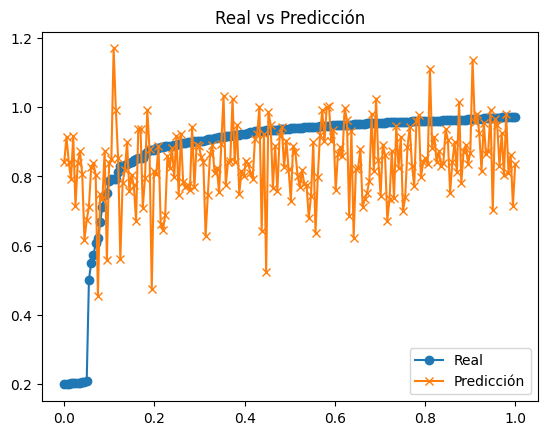

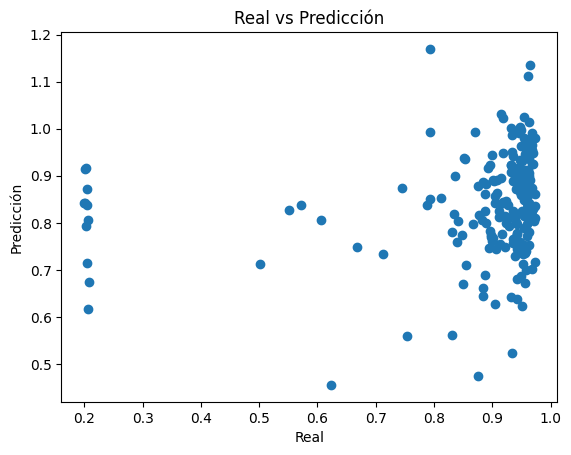

Pearson: 0.1629, Spearman: 0.2301


In [978]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)

y_test = y_test.flatten()
y_pred = y_pred.flatten()
# Grafica de la predicción y la realidad
plt.scatter(y_test, y_pred, marker="o")
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")
plt.show()
# linealidad
pearson = pearsonr(y_test, y_pred)[0]
spearman = spearmanr(y_test, y_pred)[0]
print(f"Pearson: {pearson:.4f}, Spearman: {spearman:.4f}")